In [1]:
import os
import torch
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
%matplotlib inline
import numpy as np
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from scipy import fft, fftpack
from random import randrange
import re
import importlib

import h5py
from scipy.ndimage import zoom

#from skimage.metrics import structural_similarity as ssim
#from skimage.metrics import normalized_root_mse as nrmse
#from skimage.metrics import peak_signal_noise_ratio as psnr

# functions for metrics adapted from .py file provided by Efrat
from metrics import calc_NRMSE as nrmse
from metrics import calc_SSIM as ssim

from ulf_recon_fns import ulfl1recon, applyMask, poissonDiscSigpy, find_lamda_mask, find_iter_mask, coil_combine, awgn
import display_fns

import automap_fns
import unrolling_fns
import swin_fns

from mapvbvd import mapVBVD as mapVBVD

2025-07-16 11:38:29.093977: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-16 11:38:29.964600: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/david/repos/lowfieldrecon/LowFieldReconPrivate/.venvkerasandtf/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
R = 2 # acceleration factor
calib_size = 10

loss_fn = 'mse'
#loss_fn = 'perceptual'

In [4]:
# defining PD mask
imSize = np.array([75, 64, 25])

in_seed = 0#randrange(100)
if R==1:
  mask = poissonDiscSigpy(imSize,R, in_seed,calib_size)  
elif R==2:
  mask = poissonDiscSigpy(imSize,R, in_seed,calib_size)
elif R==4:
  mask = poissonDiscSigpy(imSize,R+0.5, in_seed,calib_size)  
mask.shape

(75, 25)

In [5]:
if R==2:
    unroll_model_pth = 'trained_models/Unrolling/Unroll_mse_R2.pth'
    model_real_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_real_noise_bkgd_20240318/checkpoint/model.keras' #fast mri model
    model_imag_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_imag_noise_bkgd_20240318/checkpoint/model.keras'
    model_swin_pth = 'trained_models/SwinCascade/swincascade_model_best_R2.pth'
    
elif R==4:
    unroll_model_pth = 'trained_models/Unrolling/Unroll_mse_R4.pth'
    model_real_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r4_real_noise_bkgd_20240328/checkpoint/model.keras' #fast mri model
    model_imag_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r4_imag_noise_bkgd_20240328/checkpoint/model.keras'
    model_swin_pth = 'trained_models/SwinCascade/swincascade_model_best_R4.pth'


## High-field Reconstruction

### Load data

In [6]:
#seq = 'gre'
seq = 'mprage'
#seq = 'trufi'

match seq:
    case 'gre':
        twixfilename = 'data/highfield_JULY2024/meas_MID00063_FID47114_gre.dat'
    case 'mprage':
        twixfilename = 'data/highfield_JULY2024/meas_MID00064_FID47115_T1w_mpr_1mm_iso.dat'
    case 'trufi':
        twixfilename = 'data/highfield_JULY2024/meas_MID00062_FID47113_trufi.dat'
twixObj = mapVBVD(twixfilename)
twixObj = twixObj[1]

# mdh_flags = twixObj.MDH_flags()
# for mdh in mdh_flags:
#     print(f'MDH: {mdh}')
#     print(twixObj[mdh])
#     print('\n')

pymapVBVD version 0.6.0
Software version: VD


Scan 1/2, read all mdhs:   0%|          | 0.00/4.76M [00:00<?, ?B/s]

Scan 2/2, read all mdhs:   0%|          | 0.00/111M [00:00<?, ?B/s]

In [7]:
twixObj.image.flagRemoveOS = True
twixObj.image.squeeze = True
ksp_HR = twixObj.image['']
ksp_HR = np.flip(np.swapaxes(np.swapaxes(ksp_HR,0,2),1,2),axis=1)*1e6

match seq:
    case 'gre':
        APcrop = 80
        LRcrop = 75
        SIcrop = 52
    case 'mprage':
        APcrop = 96
        LRcrop = 63
        SIcrop = 52
    case 'trufi':
        APcrop = 96
        LRcrop = 91
        SIcrop = 52

ksp_hf_LR_crop = ksp_HR[SIcrop-1:-SIcrop,APcrop-1:-APcrop-1,LRcrop-1:-LRcrop]

ksp_hf_LR_crop.shape

read data:   0%|          | 0/25600 [00:00<?, ?it/s]

/home/david/repos/lowfieldrecon/LowFieldReconPrivate/.venvkerasandtf/lib/python3.10/site-packages/mapvbvd/twix_map_obj.py:779: RuntimeWarning: invalid value encountered in add
  raw = (raw[:, 0] + 1j * raw[:, 1]).reshape(readShape, order='F')


(25, 64, 75)

In [8]:
ksp_hf_LR = np.swapaxes(ksp_hf_LR_crop,0,2)
ksp_hf_LR = ksp_hf_LR[np.newaxis,:]

ksp_hf_LR.shape

(1, 75, 64, 25)

### Scale Data

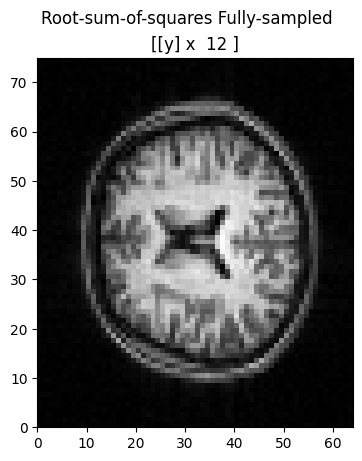

In [9]:
# stock standard recon to get an appropriate scaling factor for the ksp data
img_hf_LR_rss = np.sum(np.abs(sp.ifft(ksp_hf_LR, axes=(-1, -2, -3)))**2, axis=0)**0.5
volume_hf_rss = img_hf_LR_rss

pl.ImagePlot(img_hf_LR_rss, x=1,y=0,title='Root-sum-of-squares Fully-sampled')

# scaling all numbers to sensible values from the beginning
scale_factor = np.percentile(abs(volume_hf_rss),95) 
ksp_hf_scaled = ksp_hf_LR/scale_factor

yshift = -2

ksp_hf_scaled = np.roll(ksp_hf_scaled,(0,yshift,0),axis=(1,2,3))

if ksp_hf_scaled.shape[0] == 1:
    mps = np.ones(ksp_hf_scaled.shape,dtype=complex)
else:
    mps = mr.app.EspiritCalib(ksp_hf_scaled, calib_width=20, kernel_width=6, show_pbar=True).run()
#mps = np.ones(kspGTscaled.shape)
img_hf_fs = sp.ifft(ksp_hf_scaled, axes=(-1, -2, -3))
volume_hf_scaled = coil_combine(img_hf_fs,mps)

#vol_hf_LR = sp.ifft(ksp_hf_LR)

In [10]:
mask_hf_metrics = np.ma.getmask(np.ma.masked_less(abs(volume_hf_scaled),0.15))

volume_hf_masked = np.copy(volume_hf_scaled)
volume_hf_masked[mask_hf_metrics]=0

ksp_hf_test = ksp_hf_scaled

#optional recentering of k-space to correct phase map
delta_x = 0
delta_y = 0
delta_z = 0
ksp_hf_test = np.roll(ksp_hf_test,(delta_x,delta_y,delta_z),axis=(1,2,3))

us_hf_kspace = applyMask(ksp_hf_test,mask)

### Reconstruct Data

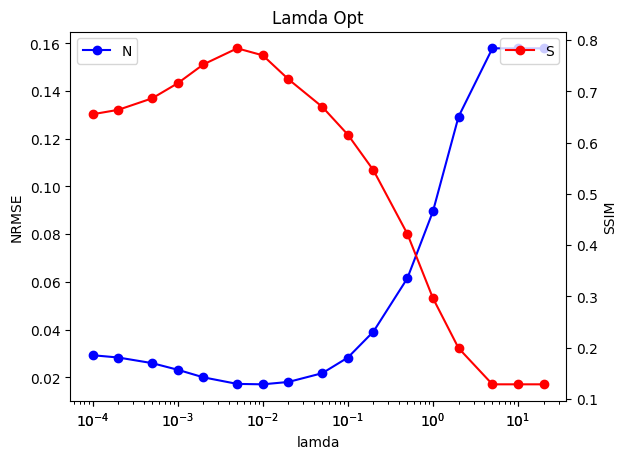

Minimum NRMSE for lamda value of  0.01


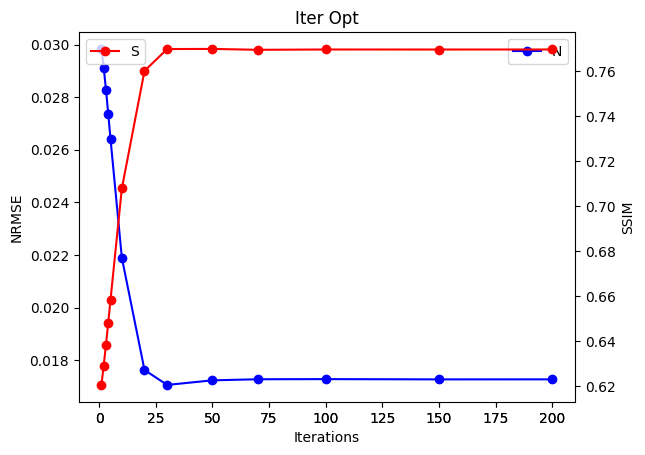

Minimum NRMSE for iter value of  30


In [11]:
no_masks = 1
lamda_hf_opt=0.01
iter_hf_opt = 30
lamda_hf_opt = find_lamda_mask(us_hf_kspace, volume_hf_scaled, mps,calib_size, show_plot=True)
iter_hf_opt = find_iter_mask(us_hf_kspace,volume_hf_scaled, lamda_hf_opt, mps, show_plot=True)

vol_hf_csrecon = ulfl1recon(us_hf_kspace,mask,lamda_hf_opt,iter_hf_opt,mps)

vol_hf_ifftrecon_mc = sp.ifft(us_hf_kspace,axes=[1,2,3])
vol_hf_ifftrecon = coil_combine(vol_hf_ifftrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

In [12]:
vol_hf_unrollrecon = unrolling_fns.unrollingRecon(us_hf_kspace,mask,unroll_model_pth)
#volunrollrecon = np.roll(volunrollrecon,(1,1),axis=(0,2))
vol_hf_amaprecon, vol_hf_amaprecon_mc = automap_fns.automapRecon(us_hf_kspace,mps,model_real_dir,model_imag_dir)

model_swin = swin_fns.load_swincascade_model(model_swin_pth, device=device)
vol_hf_swinrecon, _ = swin_fns.swinRecon(us_hf_kspace, mask, model_swin, device=device)

2025-07-16 11:39:18.591501: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-07-16 11:39:18.591609: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: autobeast
2025-07-16 11:39:18.591619: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: autobeast
2025-07-16 11:39:18.591703: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.163.1
2025-07-16 11:39:18.591729: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 550.163.1
2025-07-16 11:39:18.591736: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 550.163.1
/home/david/repos/lowfieldrecon/LowFieldReconPrivate/.venvkerasandtf/lib/python3.10/site-packages/torch/functional.py:554: UserWar

## ULF Reconstruction

In [13]:
filename = 'data/volunteer_20240709/20240709_run18_QuadHeadCoil_95Litz_3D_64x75x25_TxOuter_FS_NA48_ActiveTxPlusBothRxs_Head_GlobalShims.mat'
data = loadmat(filename)
ksp_load = data['i_kspace']

In [14]:
if np.ndim(ksp_load) > 3:
    ksp_ulf = np.moveaxis(ksp_load,3,0)
else:
    ksp_ulf = np.reshape(ksp_load,(1,ksp_shp[0],ksp_shp[1],ksp_shp[2]))

In [15]:
# ksp_ulf = ksp_ulf[0,:,:,:]+1j*ksp_ulf[1,:,:,:] #channel zero is noisy
ksp_ulf = ksp_ulf[1,:,:,:]
ksp_ulf = ksp_ulf[np.newaxis,:]

### Scale Data

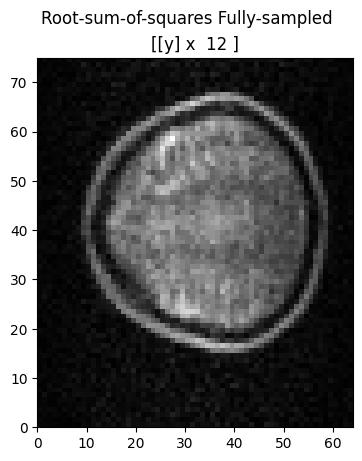

In [16]:
# stock standard recon to get an appropriate scaling factor for the ksp data
img_ulf_rss = np.sum(np.abs(sp.ifft(ksp_ulf, axes=(-1, -2, -3)))**2, axis=0)**0.5
volume_ulf_rss = img_ulf_rss

pl.ImagePlot(img_ulf_rss, x=1,y=0,title='Root-sum-of-squares Fully-sampled')

# scaling all numbers to sensible values from the beginning
scale_factor = np.percentile(abs(volume_ulf_rss),95) 
ksp_ulf_scaled = ksp_ulf/scale_factor

yshift = -2

ksp_ulf_scaled = np.roll(ksp_ulf_scaled,(0,yshift,0),axis=(1,2,3))

if ksp_ulf_scaled.shape[0] == 1:
    mps = np.ones(ksp_ulf_scaled.shape,dtype=complex)
else:
    mps = mr.app.EspiritCalib(ksp_ulf_scaled, calib_width=20, kernel_width=6, show_pbar=True).run()
#mps = np.ones(kspGTscaled.shape)
img_ulf_fs = sp.ifft(ksp_ulf_scaled, axes=(-1, -2, -3))
volume_ulf_scaled = coil_combine(img_ulf_fs,mps)

#vol_ulf = sp.ifft(ksp_ulf)

In [17]:
mask_ulf_metrics = np.ma.getmask(np.ma.masked_less(abs(volume_ulf_scaled),0.20))

volume_ulf_masked = np.copy(volume_ulf_scaled)
volume_ulf_masked[mask_ulf_metrics]=0

ksp_ulf_test = ksp_ulf_scaled

#optional recentering of k-space to correct phase map
delta_x = 0
delta_y = 0
delta_z = 0
ksp_ulf_test = np.roll(ksp_ulf_test,(delta_x,delta_y,delta_z),axis=(1,2,3))

us_ulf_kspace = applyMask(ksp_ulf_test,mask)

### Reconstruct Data

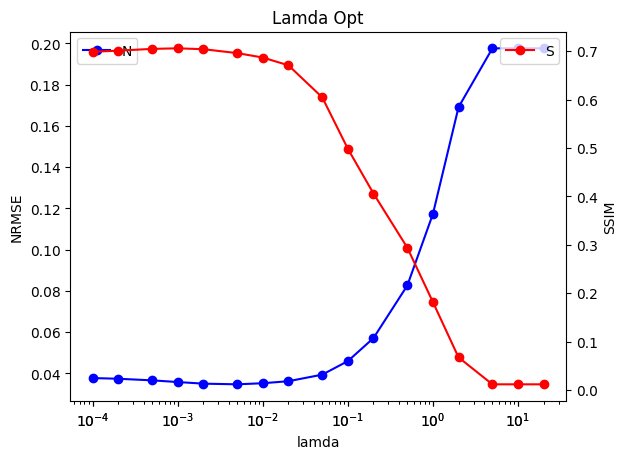

Minimum NRMSE for lamda value of  0.005


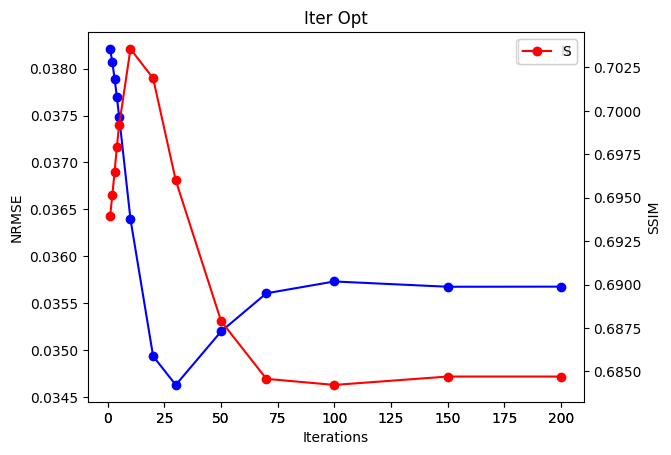

Minimum NRMSE for iter value of  30


In [18]:
no_masks = 1
lamda_ulf_opt=0.01
iter_ulf_opt = 30
lamda_ulf_opt = find_lamda_mask(us_ulf_kspace, volume_ulf_scaled, mps,calib_size, show_plot=True)
iter_ulf_opt = find_iter_mask(us_ulf_kspace,volume_ulf_scaled, lamda_ulf_opt, mps, show_plot=True)



In [19]:
vol_ulf_csrecon = ulfl1recon(us_ulf_kspace,mask,lamda_ulf_opt,iter_ulf_opt,mps)

vol_ulf_ifftrecon_mc = sp.ifft(us_ulf_kspace,axes=[1,2,3])
vol_ulf_ifftrecon = coil_combine(vol_ulf_ifftrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

In [20]:
vol_ulf_unrollrecon = unrolling_fns.unrollingRecon(us_ulf_kspace,mask,unroll_model_pth)
vol_ulf_amaprecon, vol_ulf_amaprecon_mc = automap_fns.automapRecon(us_ulf_kspace,mps,model_real_dir,model_imag_dir)
model_swin = swin_fns.load_swincascade_model(model_swin_pth, device=device)
vol_ulf_swinrecon, _ = swin_fns.swinRecon(us_ulf_kspace, mask, model_swin, device=device)

### Masking backgrounds

In [21]:
vol_high_ref = volume_hf_masked
vol_low_ref = volume_ulf_masked

# -----------------------------
# 1 - IFFT
vol1_high = np.copy(vol_hf_ifftrecon[:, :, 1:])
vol1_high[mask_hf_metrics[:, :, 1:]] = 0

vol1_low = np.copy(vol_ulf_ifftrecon[:, :, 1:])
vol1_low[mask_ulf_metrics[:, :, 1:]] = 0

# -----------------------------
# 2 - Compressed Sensing
vol2_high = np.copy(vol_hf_csrecon[:, :, 1:])
vol2_high[mask_hf_metrics[:, :, 1:]] = 0

vol2_low = np.copy(vol_ulf_csrecon[:, :, 1:])
vol2_low[mask_ulf_metrics[:, :, 1:]] = 0

# -----------------------------
# 3 - AUTOMAP
vol3_high = np.copy(vol_hf_amaprecon[:, :, 1:])
vol3_high[mask_hf_metrics[:, :, 1:]] = 0

vol3_low = np.copy(vol_ulf_amaprecon[:, :, 1:])
vol3_low[mask_ulf_metrics[:, :, 1:]] = 0

# -----------------------------
# 4 - Unrolled
vol4_high = np.copy(vol_hf_unrollrecon[:, :, 1:])
vol4_high[mask_hf_metrics[:, :, 1:]] = 0

vol4_low = np.copy(vol_ulf_unrollrecon[:, :, 1:])
vol4_low[mask_ulf_metrics[:, :, 1:]] = 0

# -----------------------------
# 5 - Swin
vol5_high = np.copy(vol_hf_swinrecon[:, :, 1:])
vol5_high[mask_hf_metrics[:, :, 1:]] = 0

vol5_low = np.copy(vol_ulf_swinrecon[:, :, 1:])
vol5_low[mask_ulf_metrics[:, :, 1:]] = 0





In [22]:
# -----------------------------
# Titles for plotting or metrics
vol1title = 'Zero-filled'
vol2title = 'Comp. Sens.'
vol3title = 'AUTOMAP'
vol4title = 'Unrolled AI'
vol5title = 'Swin Cascade'

## Comparing images

In [23]:
slc_hf=13
slc_ulf=15

ref_hf = volume_hf_masked[:,:,1:]
ref_ulf = volume_ulf_masked[:,:,1:]

asp_ratio = (ref_hf.shape[1]*3.5)/(ref_hf.shape[0]*2.5)

In [24]:
def crop_pe1_ro(vol, target_pe1=None, target_ro=None):
    """
    Centrally crop a 3D volume along PE1 and/or RO axes.

    Args:
        vol (np.ndarray): Input volume, shape (PE1, RO, PE2)
        target_pe1 (int or None): Desired PE1 size. If None, no cropping applied along PE1.
        target_ro (int or None): Desired RO size. If None, no cropping applied along RO.

    Returns:
        np.ndarray: Cropped volume of shape (target_pe1, target_ro, PE2)
    """
    pe1, ro, pe2 = vol.shape

    if target_pe1 is not None:
        start_pe1 = (pe1 - target_pe1) // 2
        vol = vol[start_pe1:start_pe1 + target_pe1, :, :]

    if target_ro is not None:
        start_ro = (ro - target_ro) // 2
        vol = vol[:, start_ro:start_ro + target_ro, :]

    return vol

In [25]:
# Recon volumes: IFFT → CS → Automap → Unrolled → Swin
vols_high = [vol1_high, vol2_high, vol3_high, vol4_high, vol5_high]
vols_low =  [vol1_low,  vol2_low,  vol3_low,  vol4_low,  vol5_low]
titles =    [vol1title, vol2title, vol3title, vol4title, vol5title]

#ref_hf = crop_pe1_ro(ref_hf, target_pe1=60, target_ro=56)
#vols_high = [crop_pe1_ro(v, target_pe1=60, target_ro=56) for v in vols_high]

# RO 64, 2.5 mm
# PE1 75, 3.5mm
# PE2 15, 8 mm
asp_ratio_hf = (ref_hf.shape[1]*3.5) / (ref_hf.shape[0]*2.5) / ( 1 / (60/75) )  # PE1/RO × mm
asp_ratio_ulf = (ref_ulf.shape[1]*3.5) / (ref_ulf.shape[0]*2.5)

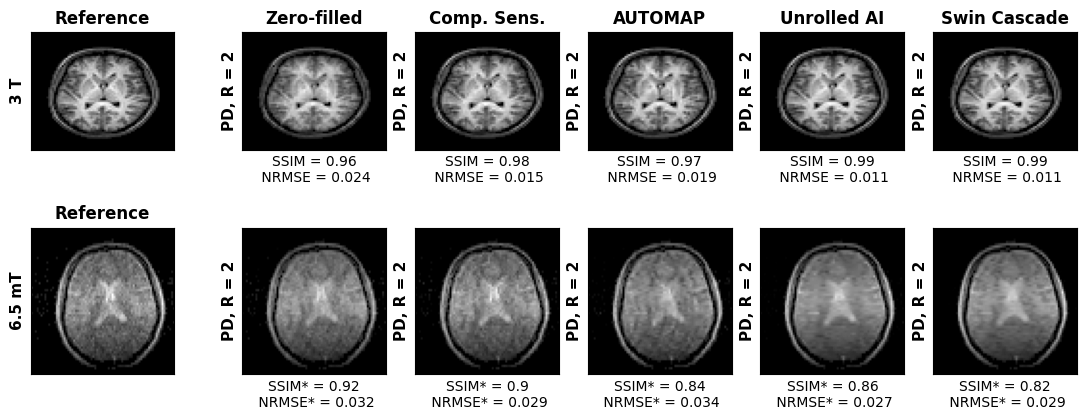

In [26]:
fig, axs = plt.subplots(2, 6, figsize=(13, 5))  # now 6 columns

max_ref_hf = np.amax(np.abs(ref_hf[:, :, slc_hf]))
max_ref_ulf = np.amax(np.abs(ref_ulf[:, :, slc_ulf]))

im_hf_clip = 1.0
im_lf_clip = 1.0

# Reference column (col 0)
for row, (ref_vol, slc, label) in enumerate([(ref_hf, slc_hf, '3 T'), (ref_ulf, slc_ulf, '6.5 mT')]):
    im = axs[row, 0].imshow(np.abs(ref_vol[:, :, slc].T), cmap='gray')
    axs[row, 0].set_title('Reference', fontweight='bold')
    axs[row, 0].set_xticks([])
    axs[row, 0].set_yticks([])
    axs[row, 0].set_aspect(asp_ratio_hf if row == 0 else asp_ratio_ulf)
    l, b, w, h = axs[row, 0].get_position().bounds
    axs[row, 0].set_position([l-0.03, b, w, h])
    axs[row, 0].set_ylabel(label, fontsize=11, fontweight='bold')
    im.set_clim(0, ((im_hf_clip * max_ref_hf) if row == 0 else (im_lf_clip * max_ref_ulf)))

# Recon columns (cols 1 to 5)
for col in range(5):
    # High-field row
    im = axs[0, col+1].imshow(np.abs(vols_high[col][:, :, slc_hf].T), cmap='gray')
    im.set_clim(0, im_hf_clip * max_ref_hf)
    axs[0, col+1].set_title(titles[col], fontweight='bold')
    axs[0, col+1].set_xticks([])
    axs[0, col+1].set_yticks([])
    axs[0, col+1].set_aspect(asp_ratio_hf)
    axs[0, col+1].set_xlabel('SSIM = ' + str(round(ssim(np.abs(vols_high[col]), np.abs(ref_hf)), 2)) +
                             '\n NRMSE = ' + str(round(nrmse(np.abs(vols_high[col]), np.abs(ref_hf)), 3)))
    axs[0, col+1].set_ylabel('PD, R = ' + str(R), fontsize=11, fontweight='bold')

    # Low-field row
    im = axs[1, col+1].imshow(np.abs(vols_low[col][:, :, slc_ulf].T), cmap='gray')
    im.set_clim(0, im_lf_clip * max_ref_ulf)
    axs[1, col+1].set_xticks([])
    axs[1, col+1].set_yticks([])
    axs[1, col+1].set_aspect(asp_ratio_ulf)
    axs[1, col+1].set_xlabel('SSIM* = ' + str(round(ssim(np.abs(vols_low[col]), np.abs(ref_ulf)), 2)) +
                             '\n NRMSE* = ' + str(round(nrmse(np.abs(vols_low[col]), np.abs(ref_ulf)), 3)))
    axs[1, col+1].set_ylabel('PD, R = ' + str(R), fontsize=11, fontweight='bold')

# Optional: save figure
fig.savefig('export_figs/retro_ulf_3T_comparison_' + seq + '_R' + str(R) + '.pdf', bbox_inches='tight', dpi=300)
